In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from enum import Enum, IntEnum

import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary
import torch
print (f'torch.__version__: {torch.__version__}')
import tensorflow as tf
import cv2 as cv
from torchvision import transforms

import enums
import viz
import configuration
import customdataset
import transformers
import models
import feature_helpers
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import loguniform
from tqdm.notebook import tqdm

check_torch_mps_device()
device = 'cpu'
device = 'mps'

config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)

LABELS_TO_INCLUDE = config.class_dict.keys()
# LABELS_TO_INCLUDE=[0,1,2,9]

# When num samples increases plotting PCA and TSNE can crash. So better to not run those cells during the main training.    
NUM_SAMPLES_TO_LOAD = 100
IMAGE_TYPES = [enums.ImageTypes.ORIGINAL,enums.ImageTypes.POSE, enums.ImageTypes.FACE]

torch.__version__: 1.13.0


2022-12-03 07:17:02.998866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensor([1.], device='mps:0')


/Users/rasentha/opt/anaconda3/envs/amd-gpu2/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


## Load Data

In [11]:
%%time
# Load the data
data = feature_extractor.load_data(image_types=IMAGE_TYPES, shuffle=True, sample_type=enums.SampleType.TRAIN_VALIDATION,
                                   count_per_label=NUM_SAMPLES_TO_LOAD)
print(f'Loaded {data.shape[0]} samples.')


Loading 1000 samples:   0%|          | 0/1000 [00:00<?, ?samples/s]

Loaded 1000 samples.
CPU times: user 1min 49s, sys: 18.9 s, total: 2min 8s
Wall time: 22.5 s


In [12]:
%%time
features_list = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
features_names = ['Pixel', 'Hog', 'CNN', 'Canny', 'Pose']
[pixel_features, hog_features, cnn_features, canny_features, pose_features] = features_list

Loading feature vectors:   0%|          | 0/1000 [00:00<?, ?images/s]

CPU times: user 1.78 s, sys: 1.05 s, total: 2.84 s
Wall time: 4.09 s


## Visualize Data

TypeError: argument of type 'NoneType' is not iterable

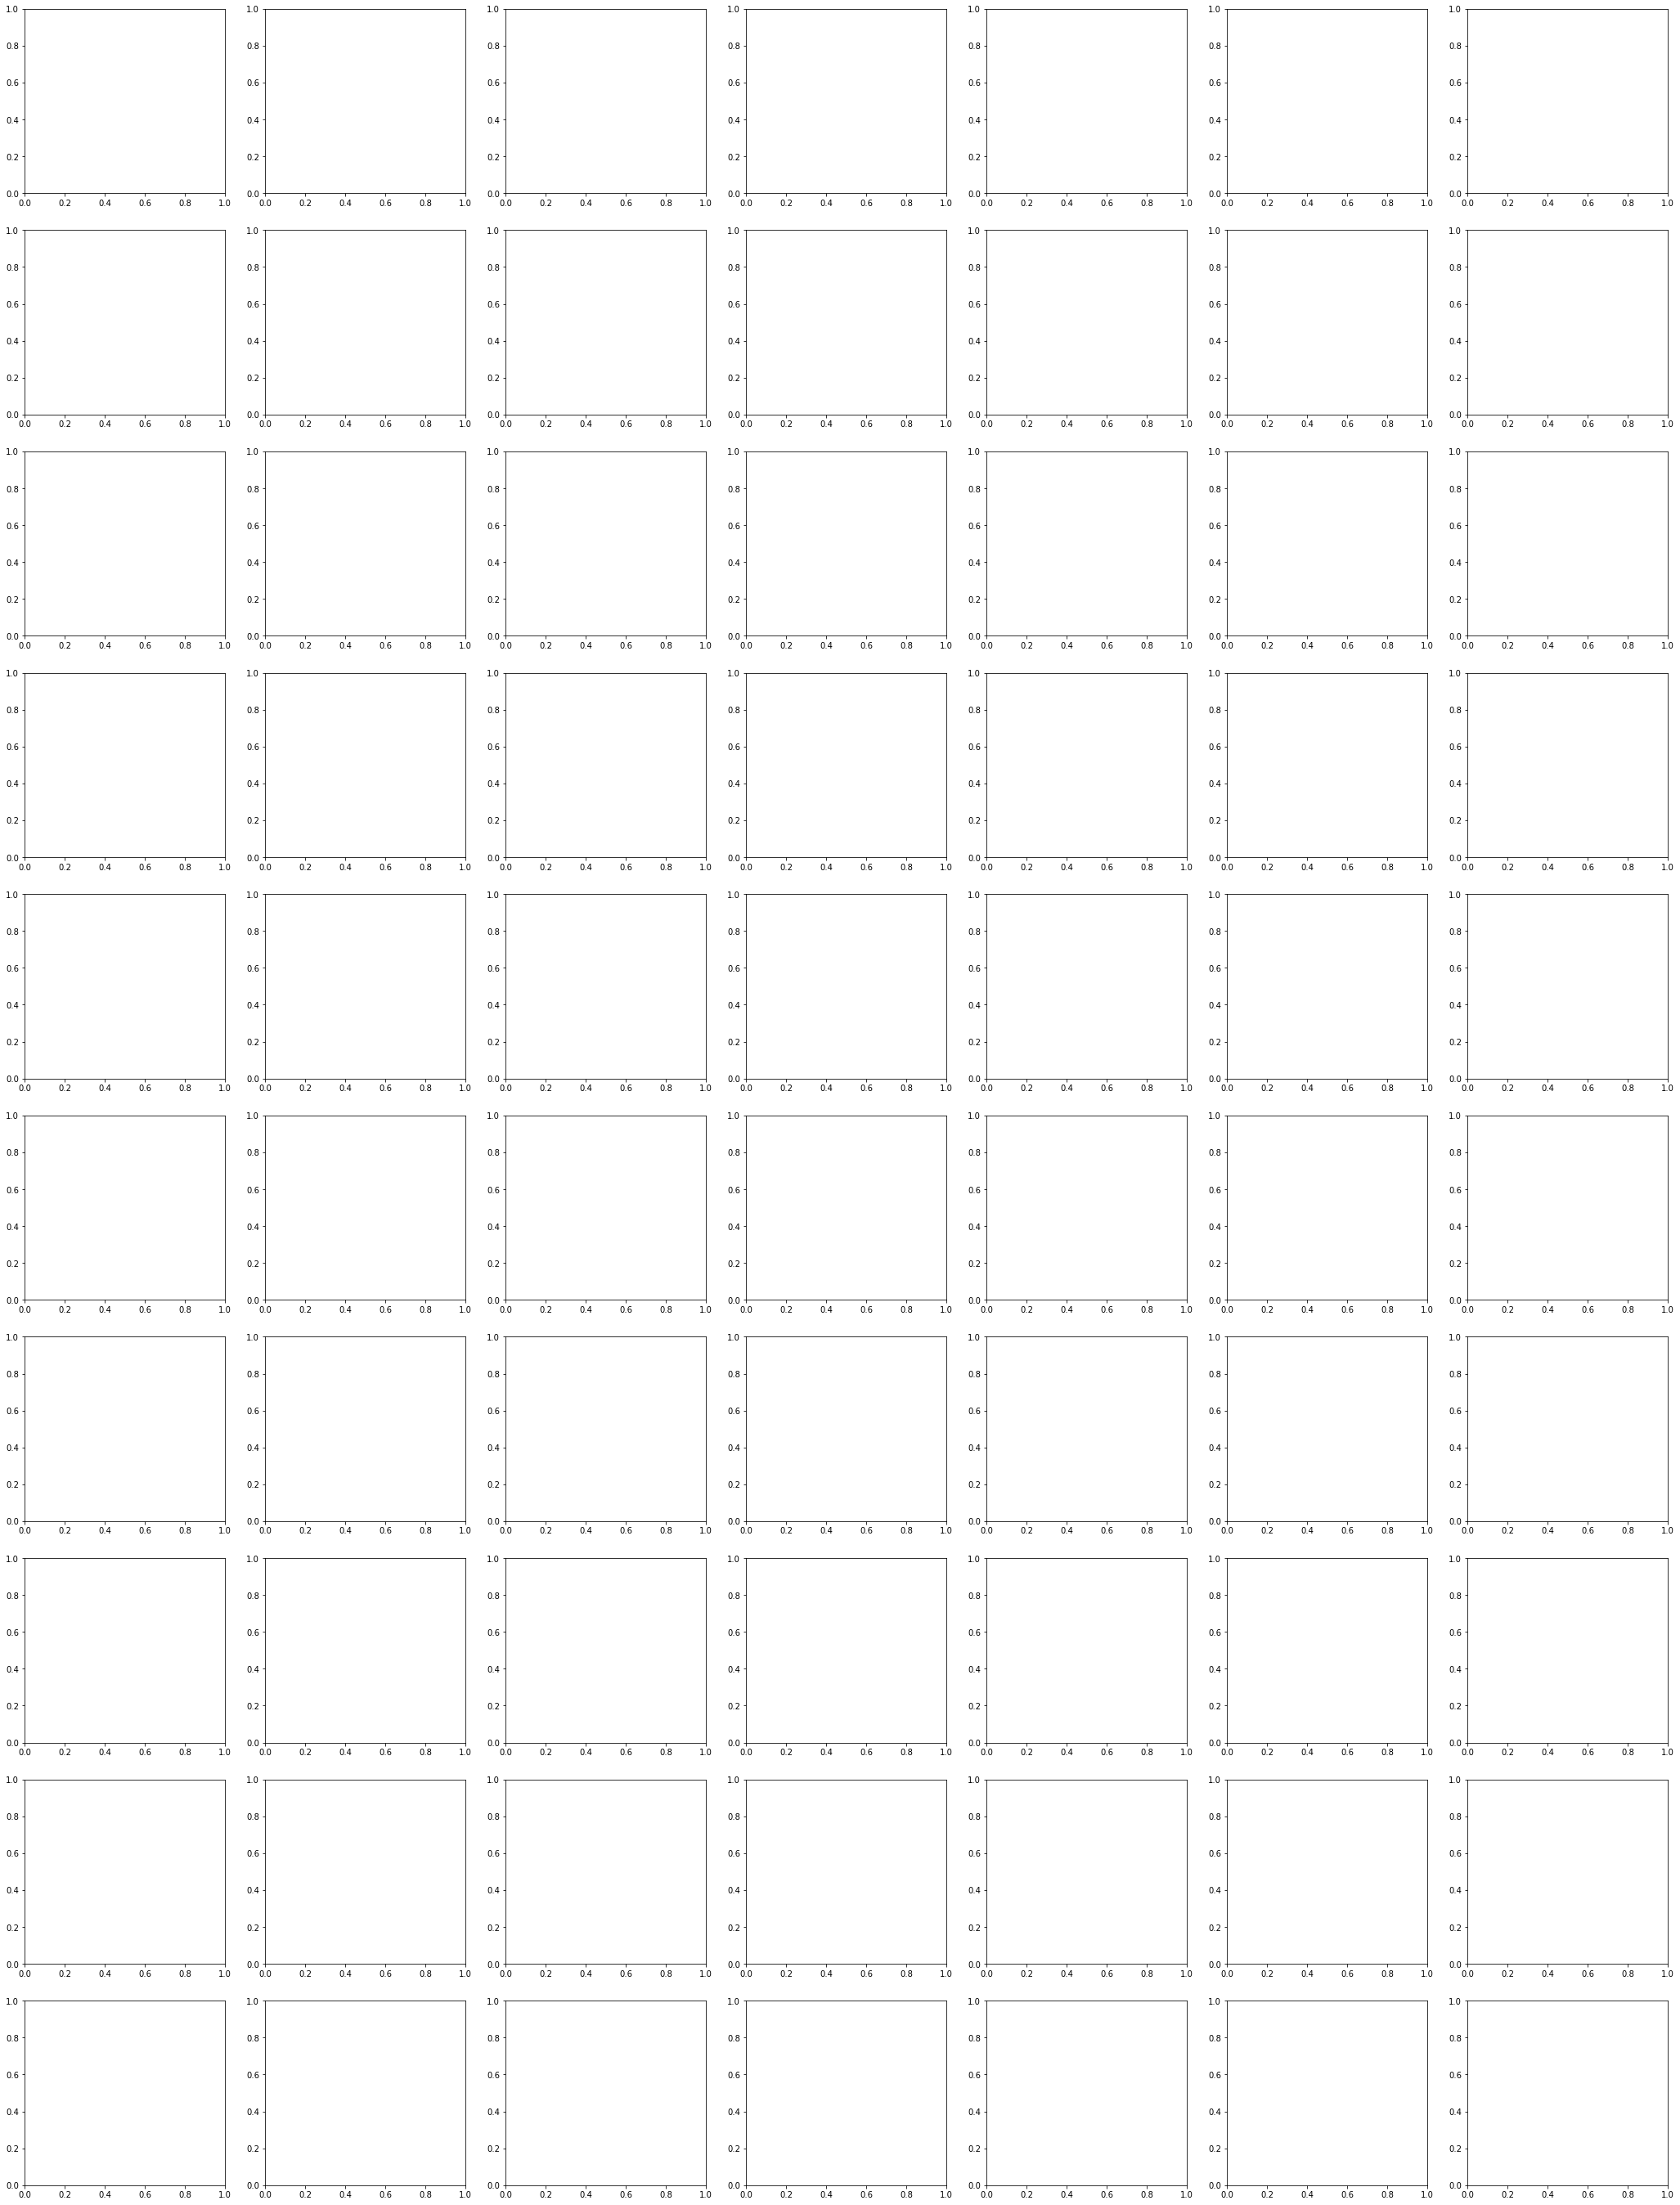

In [15]:
def plot_features(included_labels):
    def display_img(ax_idx, img, row_name, col_name, first_row, first_col):
        ax = axes[ax_idx]
        ax.imshow(img, cmap='gray')
        if first_row:
            ax.set_title(col_name, fontsize=32)
        if first_col:
            ax.set_ylabel(row_name, fontsize = 32)
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.yaxis.set_major_locator(ticker.NullLocator())
        
    count = 1
    image_types = [
        enums.ImageTypes.FACE_ANNOTATED, 
        enums.ImageTypes.POSE_ANNOTATED, 
        enums.ImageTypes.ORIGINAL,
        enums.ImageTypes.POSE, 
        enums.ImageTypes.FACE
    ]
    fig, axes = plt.subplots(nrows=len(included_labels), ncols=len(image_types) + 2, figsize=[36, 48], dpi=72)
    axes = axes.flatten()
    first_row = True
    for i, label in enumerate(included_labels):
        stack = feature_extractor.load_data_for_label(label, image_types, shuffle=True, sample_type=enums.SampleType.TRAIN_VALIDATION, count_per_label=count)
        for (item, cur_label, cur_filename) in stack:
            just_face = item[enums.ImageTypes.FACE]
            _, hogs = feature_extractor.get_hog_features([just_face])
            _, cannies = feature_extractor.get_canny_features([just_face])
            imgs_to_display = [
                ('Original', item[enums.ImageTypes.ORIGINAL]),
                ('Face Annotated', item[enums.ImageTypes.FACE_ANNOTATED]),
                ('Face Extracted', just_face),
                ('Face - Canny', cannies[0]),
                ('Face - Hog', hogs[0]),
                ('Pose Annotated', item[enums.ImageTypes.POSE_ANNOTATED]),
                ('Pose Extracted', item[enums.ImageTypes.POSE])
            ]
            images_per_label = len(imgs_to_display)
            first_col = True
            for j, item in enumerate(imgs_to_display):
                col_name, img = item
                row_name = config.class_dict[label]
                display_img(i * images_per_label + j, img, row_name, col_name, first_row, first_col)
                first_col = False
        first_row = False

    plt.suptitle('Visualizing The Features', fontsize=48)
    plt.tight_layout(pad=4, h_pad=None, w_pad=None, rect=None)
    plt.show()

plot_features(included_labels=LABELS_TO_INCLUDE)

## Dimensionality Reduction

In [19]:
# Helpers for vizualizing
def plot_PCA(X_list, names, n_components=2):
    pca_list, xpca_list = feature_extractor.get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'g-', 'r-', 'k-', 'y-']
    plot_labels = [f'{name} features' for name in names]
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=plot_labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(visible=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
    plt.show()

def plot_classes(X, y, ax, title, included_labels):
    colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
    for k, label in enumerate(included_labels):
        if X.shape[1] == 2:
            ax.scatter(X[y==label, 0], X[y==label, 1], alpha=0.5, facecolors=colorst[k], label=config.class_dict[label])
        else:
            ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], alpha=0.5, facecolors=colorst[k], label=config.class_dict[label])
    ax.set_title(title)
    
def plot_components(features_list, X_pcas, X_tsnes, names, included_labels=LABELS_TO_INCLUDE):
    # project the features into 2 dimensions
    fig, ax = plt.subplots(nrows=len(features_list), ncols=2, figsize=(10,10))

    # y is the class labels
    for i in range(len(features_list)):
        plot_classes(X_pcas[i], y, ax[i,0], title=f'{names[i]} PCA', included_labels=LABELS_TO_INCLUDE)
        plot_classes(X_tsnes[i], y, ax[i,1], title=f'{names[i]} tSNE', included_labels=LABELS_TO_INCLUDE)
    
    handles, plot_labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, plot_labels, loc='upper center')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=12, rect=None)
    plt.show()

Doing PCA(50):   0%|          | 0/5 [00:00<?, ?images/s]

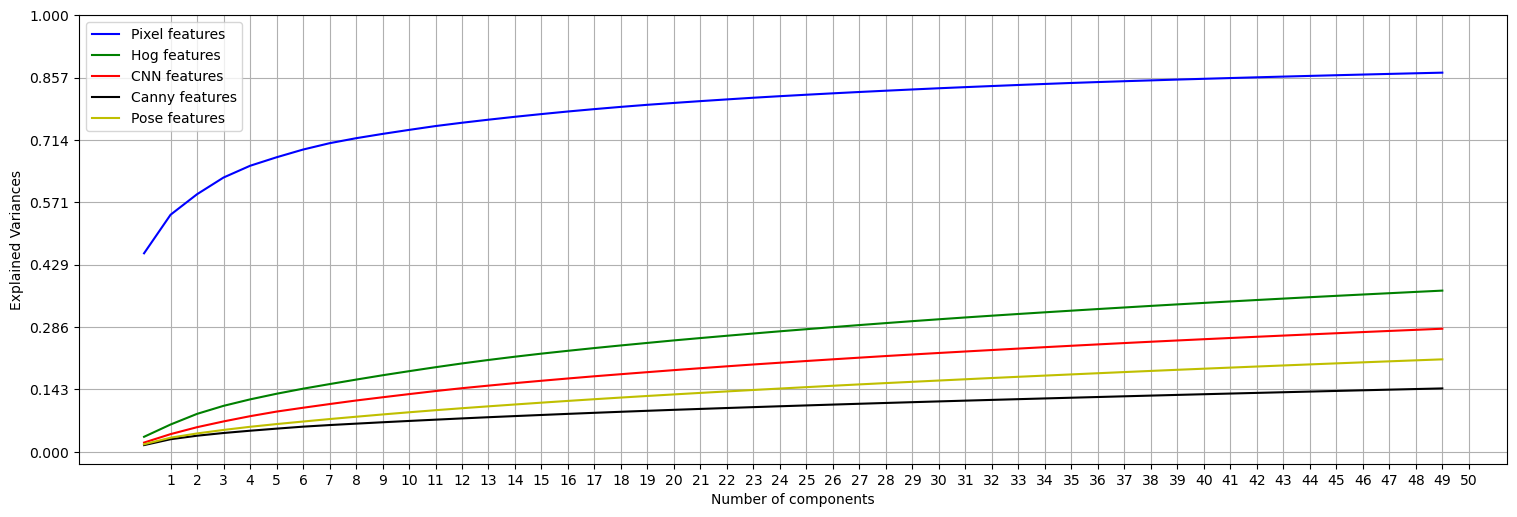

CPU times: user 26.6 s, sys: 1.55 s, total: 28.2 s
Wall time: 6.92 s


In [22]:
%%time
plot_PCA(features_list, features_names, n_components=50)

In [23]:
%%time
plot_components(features_list, 
                [X_pixels_pca, X_hog_pca, X_CNN_pca, X_canny_pca, X_pose_pca], 
                [X_pixels_tsne, X_hog_tsne, X_CNN_tsne, X_canny_tsne, X_pose_tsne],
                ['Pixel', 'Hog', 'CNN', 'Canny', 'Pose'],
                included_labels=LABELS_TO_INCLUDE)

NameError: name 'X_pixels_pca' is not defined

## KNN Classification

In [7]:
# Load feature vectors
[pixel_features, hog_features, cnn_features, canny_features, pose_features] = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
X_pixels_pca, X_hog_pca, X_CNN_pca, X_canny_pca, X_pose_pca = feature_extractor.get_PCA(features_list, n_components=2)[-1]
X_pixels_tsne, X_hog_tsne, X_CNN_tsne, X_canny_tsne, X_pose_tsne = feature_extractor.get_tsne(features_list, n_components=2)

Loading feature vectors:   0%|          | 0/2000 [00:00<?, ?images/s]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rasentha/mids/w281/project/w281-fall2022-section2-team3/input/state-farm-distracted-driver-detection/imgs/train/feature_vectors/c0/img_5716.jpg.pt'

In [24]:
def calc_accuracy(knn, pca, y, idx):
    knn.fit(pca, y)
    accuracy = 0
    for i in idx:
        label = knn.predict([pca[i,:]])
        if label[0] == y[i]:
            accuracy +=1
    return accuracy

def accuracies(n_samples):
    knn = KNeighborsClassifier(n_neighbors = 3)
    idx = np.random.choice(np.arange(len(y)), n_samples, replace=False)
    # print(y[idx])
    print(f'Accuracies from {n_samples} samples:')
    print('Pixel PCA Accuracy: ', calc_accuracy(knn, X_pixels_pca, y, idx)/n_samples)
    print('Pixel tSNE Accuracy: ', calc_accuracy(knn, X_pixels_tsne, y, idx)/n_samples)
    print('HOG PCA Accuracy: ', calc_accuracy(knn, X_hog_pca, y, idx)/n_samples)
    print('HOG tSNE Accuracy: ', calc_accuracy(knn, X_hog_tsne, y, idx)/n_samples)
    print('CNN PCA Accuracy: ', calc_accuracy(knn, X_CNN_pca, y, idx)/n_samples)
    print('CNN tSNE Accuracy: ', calc_accuracy(knn, X_CNN_tsne, y, idx)/n_samples)
    print('Canny PCA Accuracy: ', calc_accuracy(knn, X_canny_pca, y, idx)/n_samples)
    print('Canny tSNE Accuracy: ', calc_accuracy(knn, X_canny_tsne, y, idx)/n_samples)
    print('Pose PCA Accuracy: ', calc_accuracy(knn, X_pose_pca, y, idx)/n_samples)
    print('Pose tSNE Accuracy: ', calc_accuracy(knn, X_pose_tsne, y, idx)/n_samples)

print(f'Loaded {len(faces)} faces.')
print(f'hog_features:{hog_features.shape}, hog_features.min:{np.min(hog_features)}, hog_features.max:{np.max(hog_features)}')
print(f'pixel_features:{pixel_features.shape}, pixel_features.min:{np.min(pixel_features)}, pixel_features.max:{np.max(pixel_features)}')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'canny_features:{canny_features.shape}, canny_features.min:{np.min(canny_features)}, canny_features.max:{np.max(canny_features)}')
print(f'pose_features:{pose_features.shape}, pose_features.min:{np.min(pose_features)}, pose_features.max:{np.max(pose_features)}')
print()
accuracies(100)

Loaded 2000 faces.
hog_features:(2000, 5776), hog_features.min:0.0, hog_features.max:1.0
pixel_features:(2000, 25600), pixel_features.min:0.0, pixel_features.max:0.9999000430107117
cnn_features:(2000, 2048), cnn_features.min:0.0, cnn_features.max:1.607669472694397
canny_features:(2000, 25600), canny_features.min:0, canny_features.max:255
pose_features:(2000, 65536), pose_features.min:0.0, pose_features.max:0.6640035510063171

Accuracies from 100 samples:


NameError: name 'X_pixels_pca' is not defined

## Logistic Regression

In [25]:
# get the train and test split
[pixel_features, hog_features, cnn_features, canny_features, pose_features] = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=config.SEED)

Loading feature vectors:   0%|          | 0/2000 [00:00<?, ?images/s]

In [26]:
def train_classifier(in_feat, in_y, in_train_idx, val_idx):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    param_grid = {"C": loguniform(1e-3, 1e5)}
    clf = RandomizedSearchCV(LogisticRegression(solver='liblinear', random_state=config.SEED), param_grid, n_iter=500)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    return accuracy_score(y_val, y_pred)

In [ ]:
print('Pixel Feature Accuracy')
def train_and_check(features, n_components, name, y, train_idx, val_idx):
    pbar = tqdm(desc=name, total=len(n_components) + 1, position=0, leave=True)
    acc = []
    for n in n_components:
        pbar.set_description(f'{name}: Computing PCA({n})')
        _, X = feature_extractor.get_PCA([features], n_components=n+1)
        acc.append(train_classifier(X[0], y, train_idx, val_idx))
        pbar.update(1)
    pbar.set_description(f'{name}: Training classifier')
    acc.append(train_classifier(features, y, train_idx, val_idx))
    pbar.update(1)
    pbar.close()
    return acc

# get accuracy with different features
n_components = [50, 100, 150, 200]
pixel_acc = train_and_check(pixel_features, n_components, 'Pixel', y, train_idx, val_idx)
pose_acc = train_and_check(pose_features, n_components, 'Pose', y, train_idx, val_idx)
CNN_acc = train_and_check(CNN_features, n_components, 'CNN', y, train_idx, val_idx)

# pixel_tqdm = tqdm(prefix='Pixel', total=len(n_components) + 1, position=0, leave=True)
# pixel_acc = []
# for n in n_components:
#     pixel_tqdm.set_description(f'Computing PCA({n})')
#     _, X = feature_extractor.get_PCA([pixel_features], n_components=n+1)
#     pixel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
#     pixel_tqdm.update(1)
# pixel_tqdm.set_description(f'Training calssifier')
# pixel_acc.append(train_classifier(pixel_features, y, train_idx, val_idx))
# pixel_tqdm.update(1)
# pixel_tqdm.close()

# print('Pose Feature Accuracy')
# pose_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([pose_features], n_components=n+1)
#   pose_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# pose_acc.append(train_classifier(pose_features, y, train_idx, val_idx))

# print('CNN Feature Accuracy')
# CNN_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([CNN_features], n_components=n+1)
#   CNN_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# CNN_acc.append(train_classifier(CNN_features, y, train_idx, val_idx))

Pixel Feature Accuracy


Pixel:   0%|          | 0/5 [00:00<?, ?it/s]

Doing PCA(51):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(101):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(151):   0%|          | 0/1 [00:00<?, ?images/s]

Doing PCA(201):   0%|          | 0/1 [00:00<?, ?images/s]

In [ ]:
# plot the accuracy graph
plt.figure(figsize=(15,5))
plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
plt.plot(np.array(pose_acc)*100, 'g-', label='pose features')
plt.plot(np.array(CNN_acc)*100, 'k-', label='CNN features')

xtick_labels = [f'{i+1}' for i in range(n_components)] + ['All']
plt.xticks(np.arange(n_components+1), labels=xtick_labels)
plt.yticks(np.linspace(0, 100, 8))
plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()